# Maximizing Profits at the Racetrack

In [2]:
import pandas as pd
import warnings
import numpy as np
from pandas.core.common import SettingWithCopyWarning
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import ttest_ind, ttest_ind_from_stats
from tqdm import tqdm

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Reading in the data

In [4]:
races = pd.read_csv('races.csv')
run  = pd.read_csv('runs.csv')
runs = pd.merge(run, races, on='race_id')

## Adding new variables

### perf: In order to compare the finish times of horses across all races and across all distances, I will create a z score of the finish times grouped by distance. I will then multiply the z score by negative one so that I can represent a higher z score being indicative of a better race performance.

In [ ]:
dists = runs['distance'].unique()
run_df = pd.DataFrame()

for lens in dists:
    temp = runs[runs['distance'] == lens]
    temp['perf'] = (temp['finish_time'] - temp['finish_time'].mean())/temp['finish_time'].std(ddof=0)
    all_dfs = [run_df, temp]
    run_df = pd.concat(all_dfs)
    
run_df['perf'] = run_df['perf'] * -1

### career: This variable will give me the average of the horse's overall career z score. When the horse has not raced yet, I will assume that the actual value of the career average is zero.

### form: This variable will keep track of the previous three races. This is similar to career, but it takes into consideration the most recent performances. When the horse has not yet raced three races, I will substitute the form with the career average, and when the horse has not raced yet, I will make the form equal to zero.

In [ ]:
data = pd.DataFrame()
i = 0
for i in tqdm(range(run_df['horse_id'].max()-1)):
    temp = run_df[run_df['horse_id'] == i]
    temp = temp.sort_values('race_id', ascending = True)
    temp['career'] = temp['perf'].expanding().mean()
    temp['career'] = temp['career'].shift(1)
    temp['form'] = temp['perf'].rolling(3).mean()
    temp['form'] = temp['form'].shift(1)
    all_dfs = [data, temp]
    data = pd.concat(all_dfs)

data['form'].fillna(data.career, inplace=True)
data['form'] = data['form'].fillna(0)
data['career'] = data['career'].fillna(0)

100%|██████████████████████████████████████| 4403/4403 [05:19<00:00, 13.79it/s]


### counts: The count of the number of horses in a race.

In [ ]:
data = data.sort_values('race_id', ascending = True)
data["counts"] = data.groupby(["race_id"])['race_id'].transform('count')

In [ ]:
data = data[['race_id', 'horse_id', 'result', 'won', 'horse_age', 'surface', 'going','actual_weight', 'draw', 'venue', 'race_no', 'win_odds', 'place_odds', 'declared_weight', 'win_dividend1', 'perf', 'career', 'form', 'counts', 'race_class']]
data['intercept'] = 1

## Predict Performace: Now, I will predict the performances of each horse using linear regression. First, I will extract the columns that I will will use, then I will create dummy variables for each of the categorical columns 'venue', 'going', 'surface', and then I will seperate my data into a test and train so that I can train and evaluate the goodness of fit.

### Get dummy variables for venue, going, and surface.

In [ ]:
data = pd.get_dummies(data, columns=['venue', 'surface'], drop_first=True)

### Seperate my data into test and train according to the 80-20 rule.

In [ ]:
test = data[data['race_id'] > 5078]
train = data[data['race_id'] <= 5078]

### I will now train my data based off of the train dataset.  First, I will identify and remove any extraneous outliers.  Ultimately, I end up only removing around one percent of all runs.

                            OLS Regression Results                            
Dep. Variable:                   perf   R-squared:                       0.292
Model:                            OLS   Adj. R-squared:                  0.292
Method:                 Least Squares   F-statistic:                     2596.
Date:                Thu, 27 May 2021   Prob (F-statistic):               0.00
Time:                        00:47:01   Log-Likelihood:                -66839.
No. Observations:               62889   AIC:                         1.337e+05
Df Residuals:                   62878   BIC:                         1.338e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.6785      0.076     

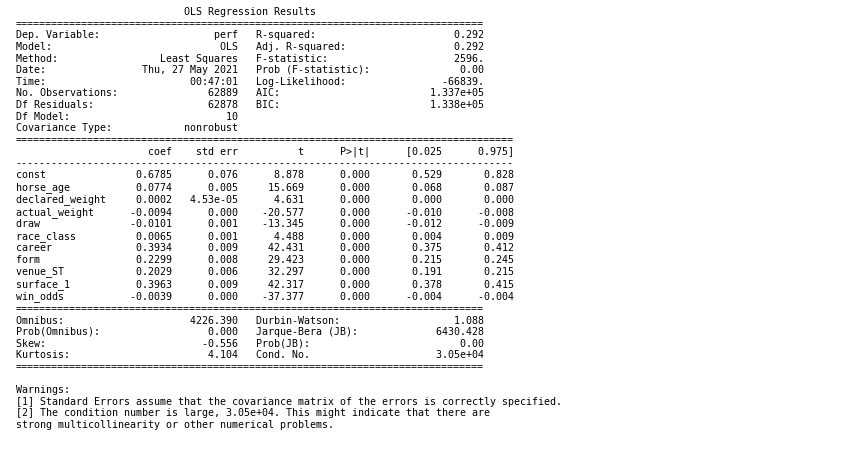

In [ ]:
train = train[train['perf'] < 3]
train = train[train['perf'] > -3]
train = train[train['career'] < 3]
train = train[train['career'] > -3]
train = train[train['form'] < 3]
train = train[train['form'] > -3]

X = train[['horse_age', 'declared_weight', 'actual_weight', 'draw', 'race_class', 'career', 'form', 'venue_ST', 'surface_1', 'win_odds']]

y = train['perf']

X = sm.add_constant(X)

model = sm.OLS(y,X)
results = model.fit()

olsmod = sm.OLS(y, X)
olsres = olsmod.fit()
print(olsres.summary())
plt.rcParams.update({
    "lines.color": "white",
    "patch.edgecolor": "white",
    "text.color": "black",
    "axes.facecolor": "white",
    "axes.edgecolor": "lightgray",
    "axes.labelcolor": "black",
    "xtick.color": "black",
    "ytick.color": "black",
    "grid.color": "lightgray",
    "figure.facecolor": "white",
    "figure.edgecolor": "white",
    "savefig.facecolor": "white",
    "savefig.edgecolor": "white"})
plt.rc('figure', figsize=(12, 7))
#plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 12}) old approach
plt.text(0.01, 0.05, str(olsres.summary()), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off')
plt.tight_layout()

### Now I will predict the horses in the test set given the model I fitted in the train set.

In [ ]:
test = data[data['race_id'] > 5078]
train = data[data['race_id'] <= 5078]
test['predicted_perf'] = results.predict(test[['intercept', 'horse_age', 'declared_weight', 'actual_weight', 'draw', 'race_class', 'career', 'form', 'venue_ST', 'surface_1', 'win_odds']])
train['predicted_perf'] = results.predict(train[['intercept','horse_age', 'declared_weight', 'actual_weight', 'draw', 'race_class', 'career', 'form', 'venue_ST', 'surface_1', 'win_odds']])

### z_perf_race: I will create a new variable that has the expected performace of the horse in the race and compare it to the average expected z score of each race.  I am doing this so that I can compare the races where horses are of a higher quality or lower quality.  I am doing this because logistic regression works best when the observations are random.  I am trying to make a new random variable so that I can test the accuracy of the regression.

In [ ]:
a = test.groupby('race_id', as_index=False)['predicted_perf'].mean()
a = a.rename(columns = {'predicted_perf':'pred_perf_race'})
test = pd.merge(test, a, on='race_id')
test['z_perf_race'] = test['predicted_perf'] - test['pred_perf_race']

a = train.groupby('race_id', as_index=False)['predicted_perf'].mean()
a = a.rename(columns = {'predicted_perf':'pred_perf_race'})
train = pd.merge(train, a, on='race_id')
train['z_perf_race'] = train['predicted_perf'] - train['pred_perf_race']

### Now I will train my model to find the probabilities of winning a race. I will then store the values of the expected win probabilities for each horse in the test set.

Optimization terminated successfully.
         Current function value: 0.246190
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                    won   No. Observations:                62889
Model:                          Logit   Df Residuals:                    62885
Method:                           MLE   Df Model:                            3
Date:                Wed, 26 May 2021   Pseudo R-squ.:                  0.1227
Time:                        17:17:47   Log-Likelihood:                -15483.
converged:                       True   LL-Null:                       -17648.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -1.0218      0.135     -7.556      0.000      -1.287      -0.757
win_odds       -0.0736    

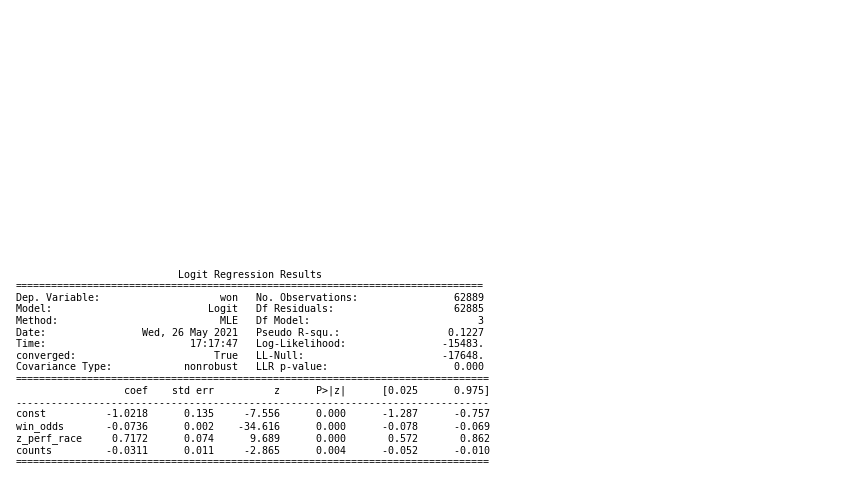

In [ ]:
train = train[train['perf'] < 3]
train = train[train['perf'] > -3]
train = train[train['career'] < 3]
train = train[train['career'] > -3]
train = train[train['form'] < 3]
train = train[train['form'] > -3]

X = train[['win_odds', 'z_perf_race', 'counts']]

y = train['won']

X = sm.add_constant(X)

lr = sm.Logit(y, X).fit()
test['predicted_win']= lr.predict(test[['intercept', 'win_odds', 'z_perf_race', 'counts']])

print(lr.summary())
plt.rcParams.update({
    "lines.color": "white",
    "patch.edgecolor": "white",
    "text.color": "black",
    "axes.facecolor": "white",
    "axes.edgecolor": "lightgray",
    "axes.labelcolor": "black",
    "xtick.color": "black",
    "ytick.color": "black",
    "grid.color": "lightgray",
    "figure.facecolor": "white",
    "figure.edgecolor": "white",
    "savefig.facecolor": "white",
    "savefig.edgecolor": "white"})

plt.rc('figure', figsize=(12, 7))
#plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 12}) old approach
plt.text(0.01, 0.05, str(lr.summary()), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off')
plt.tight_layout()

### As a comparison, I will also run a regressin for the probability of a horse winning a race given that the regression is solely based on the win odds.

Optimization terminated successfully.
         Current function value: 0.246960
         Iterations 9


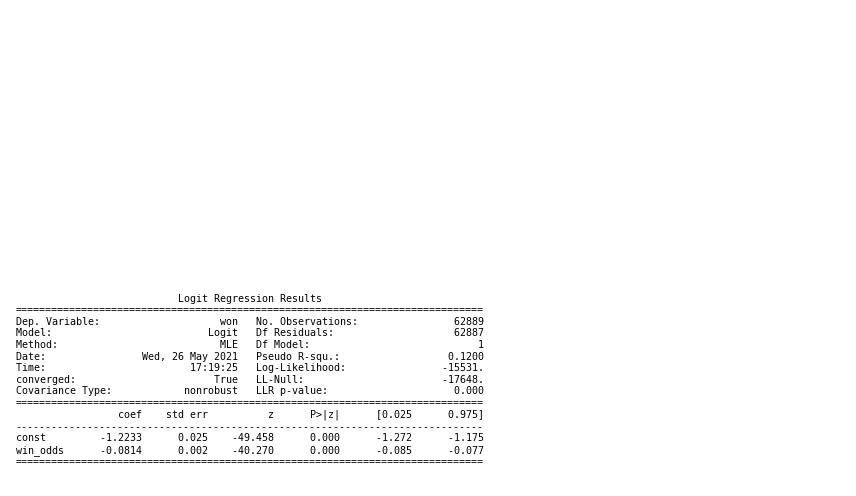

In [ ]:
train = train[train['perf'] < 3]
train = train[train['perf'] > -3]
train = train[train['career'] < 3]
train = train[train['career'] > -3]
train = train[train['form'] < 3]
train = train[train['form'] > -3]

X = train[['win_odds']] 
y = train['won']
X = sm.add_constant(X)
lrodds = sm.Logit(y, X).fit() 
test['predicted_win_odds'] = lrodds.predict(test[['intercept', 'win_odds']])
lrodds.summary()
plt.rcParams.update({
    "lines.color": "white",
    "patch.edgecolor": "white",
    "text.color": "black",
    "axes.facecolor": "white",
    "axes.edgecolor": "lightgray",
    "axes.labelcolor": "black",
    "xtick.color": "black",
    "ytick.color": "black",
    "grid.color": "lightgray",
    "figure.facecolor": "white",
    "figure.edgecolor": "white",
    "savefig.facecolor": "white",
    "savefig.edgecolor": "white"})
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(12, 7))
#plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 12}) old approach
plt.text(0.01, 0.05, str(lrodds.summary()), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off')
plt.tight_layout()

### I will find the expected payouts for each horse in each race by multiplying the win odds for each horse by ten and by the expected win probability.  Through this, I can end up with the expected payout for a ten dollar bet.

In [ ]:
test['exp_payout'] = test['win_odds'] * test['predicted_win'] * 10
test['exp_payout_odd'] = test['win_odds'] * test['predicted_win_odds'] * 10

# Evaluation:

### In this algorithm, I am simulating a random bettor and a bettor with our racing strategy.  The random bettor will always choose a random horse in each race while a bettor who chooses based on our predictions choose a horse at random given that the expected payout of the horse is greater than 10.  There is always a case of a horse having a payout greater than ten (except for one race).  I will save one simulation for both the random bettor and our bettor by the lists earnings and avg_earnings.

In [ ]:
earn = []
rnd_earn = []
simuls = 1000
for j in tqdm(range(simuls)):
  i = 5079
  earnings = 0
  avg_earnings = 0
  while (i < 6348):
    if (i == 6108):    
        i += 1
    temp_df = test[test['race_id'] == i]
    rand = random.randint(0, len(temp_df) - 1)  
    
    if (temp_df.iloc[rand]['won'] == 1):
      avg_earnings += temp_df.iloc[rand]['win_dividend1'] - 10
    else:
      avg_earnings += -10
    
    if (temp_df['exp_payout'].max() < 10):
      i += 1        
    else:
      random_num = random.randint(0, len(temp_df) - 1)
      while (temp_df.iloc[random_num]['exp_payout'] < 10):
        random_num = random.randint(0, len(temp_df) - 1)    
      if (temp_df.iloc[random_num]['won'] == 1):
          earnings += temp_df.iloc[rand]['win_dividend1'] - 10
      else:
          earnings += -10
    
    i += 1
  earn.append(earnings)
  rnd_earn.append(avg_earnings)



  0%|                                                   | 0/10 [00:00<?, ?it/s]

 10%|████▎                                      | 1/10 [00:02<00:20,  2.31s/it]

 20%|████████▌                                  | 2/10 [00:04<00:17,  2.24s/it]

 30%|████████████▉                              | 3/10 [00:06<00:15,  2.28s/it]

 40%|█████████████████▏                         | 4/10 [00:08<00:13,  2.24s/it]

 50%|█████████████████████▌                     | 5/10 [00:11<00:11,  2.24s/it]

 60%|█████████████████████████▊                 | 6/10 [00:13<00:08,  2.21s/it]

 70%|██████████████████████████████             | 7/10 [00:15<00:06,  2.21s/it]

 80%|██████████████████████████████████▍        | 8/10 [00:17<00:04,  2.21s/it]

 90%|██████████████████████████████████████▋    | 9/10 [00:20<00:02,  2.25s/it]

100%|██████████████████████████████████████████| 10/10 [00:22<00:00,  2.23s/it]


### Like the previous code cell, I am creating a bettor that only chooses based on the expected payout of the win_odds.  A bettor who chooses by this method will choose a horse such that it has a higher expected payout than 10.

In [ ]:
odd_earn = []
simuls = 1000
for j in tqdm(range(simuls)):
  i = 5079
  suma = 0
  while (i < 6348):
    if (i == 6108):    
        i += 1
    temp_df = test[test['race_id'] == i]
      
    if (temp_df['exp_payout_odd'].max() < 10):
        i += 1    
    else:
        random_num = random.randint(0, len(temp_df)- 1)
    
        while (temp_df.iloc[random_num]['exp_payout_odd'] < 10):
          random_num = random.randint(0, len(temp_df) - 1)
    
        if (temp_df.iloc[random_num]['won'] == 1):
          suma += temp_df.iloc[random_num]['win_dividend1'] - 10
    
        else:
          suma += -10
    
    i += 1
  odd_earn.append(suma)




  0%|                                                   | 0/10 [00:00<?, ?it/s]

 10%|████▎                                      | 1/10 [00:01<00:17,  1.97s/it]

 20%|████████▌                                  | 2/10 [00:03<00:15,  1.95s/it]

 30%|████████████▉                              | 3/10 [00:05<00:13,  1.93s/it]

 40%|█████████████████▏                         | 4/10 [00:07<00:11,  1.88s/it]

 50%|█████████████████████▌                     | 5/10 [00:09<00:09,  1.84s/it]

 60%|█████████████████████████▊                 | 6/10 [00:11<00:07,  1.82s/it]

 70%|██████████████████████████████             | 7/10 [00:12<00:05,  1.84s/it]

 80%|██████████████████████████████████▍        | 8/10 [00:14<00:03,  1.88s/it]

 90%|██████████████████████████████████████▋    | 9/10 [00:17<00:02,  2.00s/it]

100%|██████████████████████████████████████████| 10/10 [00:19<00:00,  1.94s/it]


## Results

### This graph contains the histogram of all earnings made from each possible betting strategy.

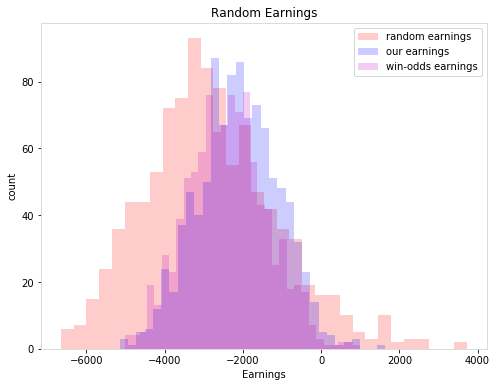

In [ ]:
import numpy as np
import random
from matplotlib import pyplot as plt

plt.rcParams.update({
    "lines.color": "white",
    "patch.edgecolor": "white",
    "text.color": "black",
    "axes.facecolor": "white",
    "axes.edgecolor": "lightgray",
    "axes.labelcolor": "black",
    "xtick.color": "black",
    "ytick.color": "black",
    "grid.color": "lightgray",
    "figure.facecolor": "white",
    "figure.edgecolor": "white",
    "savefig.facecolor": "white",
    "savefig.edgecolor": "white"})
bin = 32
plt.hist(rnd_earn, bins=bin, alpha = .2, color = 'r', label = "random earnings")
plt.hist(earn, bins=bin, alpha =.2, color = 'b', label = "our earnings")
plt.hist(odd_earn, bins=bin, alpha = .2, color = 'm', label = "win-odds earnings")
plt.title('Random Earnings')
plt.xlabel('Earnings')
plt.ylabel('count')
plt.legend()
plt.show()

## Here are the expected returns for each betting strategy and their respective Welch's ttests.

In [ ]:
t, p = ttest_ind(odd_earn, rnd_earn, equal_var=False)
print("ttest between odd_earn and rnd_earn is " + str(p))
t, p = ttest_ind(earn, rnd_earn, equal_var=False)
print("ttest between earn and rnd_earn is " + str(p))
t, p = ttest_ind(odd_earn, earn, equal_var=False)
print("ttest between odd_earn and earn is " + str(p))
print("expected return of our strategy" + str(np.mean(earn)/15902))
print("expected return of odd strategy" + str(np.mean(odd_earn)/15902))
print("expected return of random strategy" + str(np.mean(rnd_earn)/15902))

ttest between odd_earn and rnd_earn is 8.237486063795681e-11
ttest between earn and rnd_earn is 9.075403645210065e-27
ttest between odd_earn and earn is 1.4906286329982914e-09
expected return of our strategy-0.13351191674003268
expected return of odd strategy-0.1509353226009307
expected return of random strategy-0.17665746446987798


# Miscellaneous Graphs

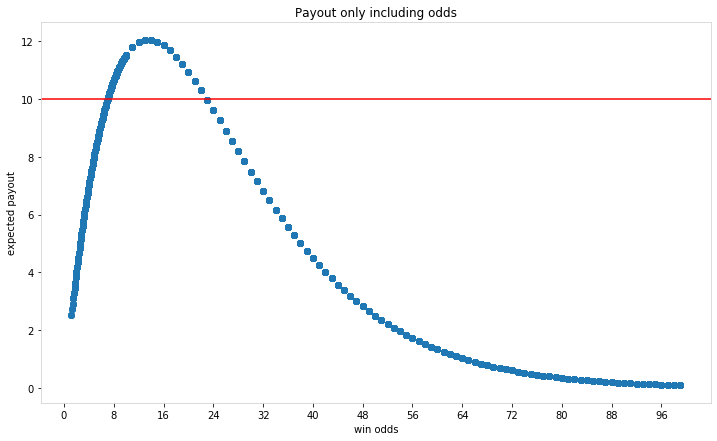

In [ ]:
X = test['win_odds']
y = test['exp_payout_odd']
y2 = test['exp_payout']
plt.scatter(X,y)
plt.ylabel('expected payout')
plt.xlabel('win odds')
plt.xticks(np.arange(0, 99, 8))
plt.title('Payout only including odds')
plt.axhline(y=10, color='r', linestyle='-')
plt.show()

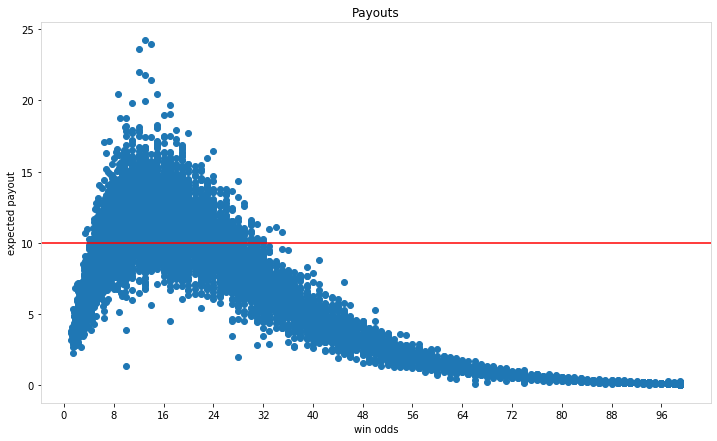

In [ ]:
X = test['win_odds']
y = test['exp_payout']
plt.scatter(X,y)
plt.ylabel('expected payout')
plt.xlabel('win odds')
plt.xticks(np.arange(0, 99, 8))
plt.title('Payouts')
plt.axhline(y=10, color='r', linestyle='-')
plt.show()

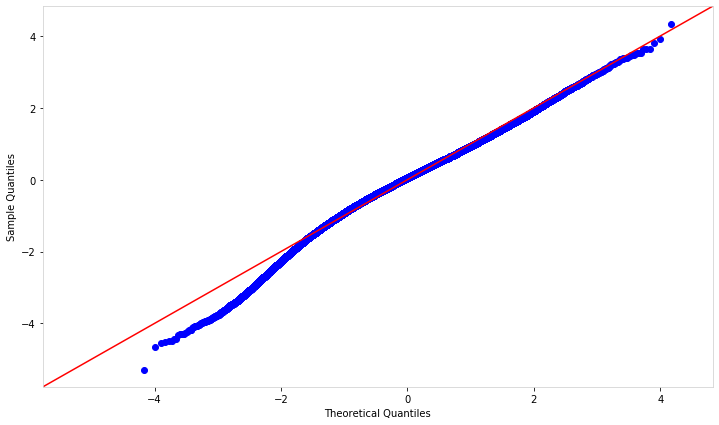

In [ ]:
res = olsres.resid
fig = sm.qqplot(res, fit=True, line="45")
plt.show()

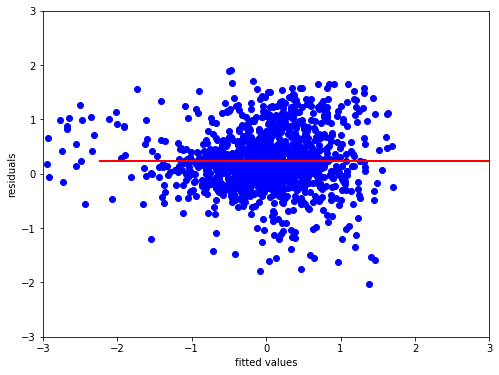

In [ ]:
train = train[train['perf'] < 3]
train = train[train['perf'] > -3]
train = train[train['career'] < 3]
train = train[train['career'] > -3]
train = train[train['form'] < 3]
train = train[train['form'] > -3]

y = train['perf']

X = train[['horse_age', 'declared_weight', 'actual_weight', 'draw', 'race_class', 'career', 'form', 'venue_ST', 'surface_1', 'win_odds']]


X = sm.add_constant(X)

olsmod = sm.OLS(y, X)
olsres = olsmod.fit()

plt.scatter(olsres.resid, olsres.fittedvalues, c = 'b')
m, b = np.polyfit(olsres.resid, olsres.fittedvalues, 1)
plt.plot(X, m*X + b, 'r')
plt.ylabel('residuals')
plt.xlabel('fitted values')
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.rc("figure", figsize=(8,6))
plt.show()

Figure(1152x2304)


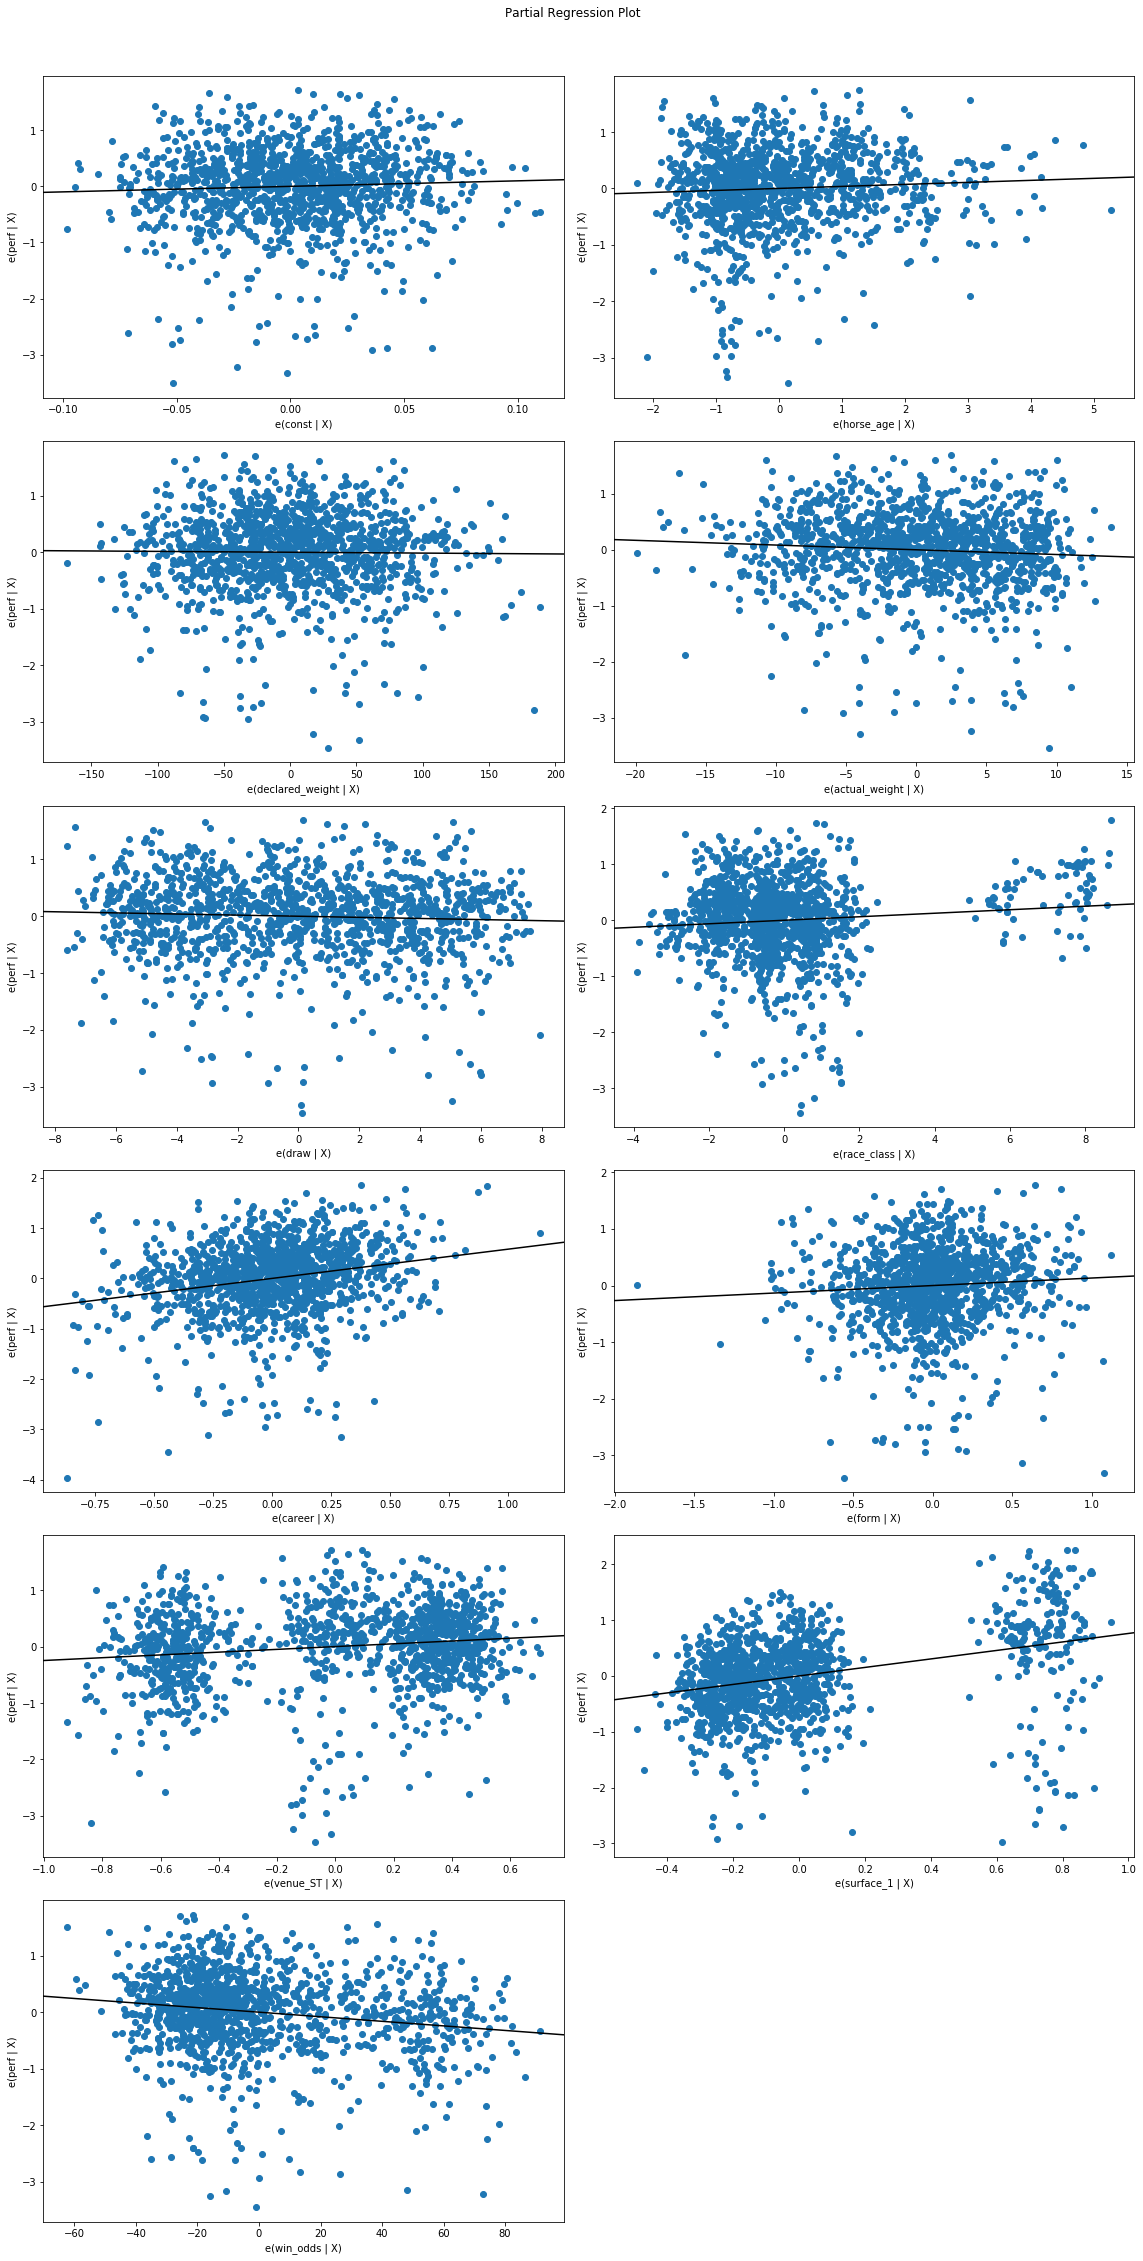

In [ ]:
fig = sm.graphics.plot_partregress_grid(olsres)

plt.rc("figure", figsize=(8,32))
print(fig)